In [5]:
# --- Import Necessary Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [7]:
# --- Load Datasets ---
dataset_path_CF = r"C:\Users\Randy\OneDrive\Documents\Desktop\Data Mining\DataSets\Finmark\Customer_Feedback_Data.csv"
dataset_path_PO = r"C:\Users\Randy\OneDrive\Documents\Desktop\Data Mining\DataSets\Finmark\Product_Offering_Data.csv"
dataset_path_TD = r"C:\Users\Randy\OneDrive\Documents\Desktop\Data Mining\DataSets\Finmark\Transaction_Data.csv"

df_CF = pd.read_csv(dataset_path_CF)
df_PO = pd.read_csv(dataset_path_PO)
df_TD = pd.read_csv(dataset_path_TD)


In [9]:
# --- Display Dataset Information ---
print("Customer Feedback Data:")
print(df_CF.info())

print("\nProduct Offering Data:")
print(df_PO.info())

print("\nTransaction Data:")
print(df_TD.info())

Customer Feedback Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer_ID              5050 non-null   int64  
 1   Satisfaction_Score       4949 non-null   float64
 2   Feedback_Comments        5050 non-null   object 
 3   Likelihood_to_Recommend  5050 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 157.9+ KB
None

Product Offering Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Product_ID           15 non-null     int64  
 1   Product_Name         15 non-null     object 
 2   Product_Type         15 non-null     object 
 3   Risk_Level           15 non-null     object 
 4   Target_Age_Group     0 non-null      float64
 

In [ ]:
# --- Data Cleaning & Feature Engineering ---

# Remove invalid satisfaction scores
df_CF = df_CF[df_CF["Satisfaction_Score"] <= 10]

# Remove Transaction Amount outliers using IQR
q1, q3 = df_TD["Transaction_Amount"].quantile([0.25, 0.75])
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
df_TD = df_TD[df_TD["Transaction_Amount"] <= upper_bound]

# Create a new feature: Satisfaction Category
def satisfaction_category(score):
    if score <= 4:
        return 'Low'
    elif 5 <= score <= 7:
        return 'Medium'
    else:
        return 'High'

df_CF['Satisfaction_Category'] = df_CF['Satisfaction_Score'].apply(satisfaction_category)

# Calculate total spending per customer
customer_transactions = df_TD.groupby("Customer_ID")["Transaction_Amount"].sum().reset_index()
customer_transactions.rename(columns={"Transaction_Amount": "Total_Spent"}, inplace=True)

# Merge with Customer Feedback dataset
df_CF = df_CF.merge(customer_transactions, on="Customer_ID", how="left")

# Fill missing values in Total_Spent with 0
df_CF["Total_Spent"].fillna(0, inplace=True)

In [33]:
print(df_CF.columns)  # Check if 'Total_Spent' exists
print(df_CF.head())   # See the first few rows


Index(['Customer_ID', 'Satisfaction_Score', 'Feedback_Comments',
       'Likelihood_to_Recommend', 'Satisfaction_Category', 'Total_Spent_x',
       'Total_Spent_y', 'Total_Spent'],
      dtype='object')
   Customer_ID  Satisfaction_Score  Feedback_Comments  \
0            1                10.0     Very satisfied   
1            2                 3.0     Very satisfied   
2            3                10.0     Very satisfied   
3            4                 7.0  Needs improvement   
4            5                 8.0     Unsatisfactory   

   Likelihood_to_Recommend Satisfaction_Category  Total_Spent_x  \
0                        9                  High        16836.0   
1                        3                   Low         4907.0   
2                        1                  High         1538.0   
3                        4                Medium         8295.0   
4                        7                  High        14798.0   

   Total_Spent_y  Total_Spent  
0        16836.0   

In [37]:
# Group transactions by Customer_ID and sum the total amount spent
customer_transactions = df_TD.groupby("Customer_ID")["Transaction_Amount"].sum().reset_index()
customer_transactions.rename(columns={"Transaction_Amount": "Total_Spent"}, inplace=True)

# Check if "Total_Spent" already exists in df_CF and drop it before merging
if "Total_Spent" in df_CF.columns:
    df_CF.drop(columns=["Total_Spent"], inplace=True)

# Merge with df_CF ensuring every customer gets a total spending value
df_CF = df_CF.merge(customer_transactions, on="Customer_ID", how="left", suffixes=("", "_new"))

# Fill missing values (customers without transactions)
df_CF["Total_Spent"] = df_CF["Total_Spent"].fillna(0)


In [39]:
# --- Clustering: Customer Segmentation ---
# Features for segmentation: Satisfaction Score, Likelihood to Recommend, and Total Spent
segmentation_features = df_CF[["Satisfaction_Score", "Likelihood_to_Recommend", "Total_Spent"]]


In [41]:

# Standardize data for clustering
scaler = StandardScaler()
segmentation_features_scaled = scaler.fit_transform(segmentation_features)


In [43]:

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_CF["Customer_Segment"] = kmeans.fit_predict(segmentation_features_scaled)

In [45]:
# Rename clusters for clarity
segment_labels = {0: "Low Value", 1: "Medium Value", 2: "High Value"}
df_CF["Customer_Segment"] = df_CF["Customer_Segment"].map(segment_labels)


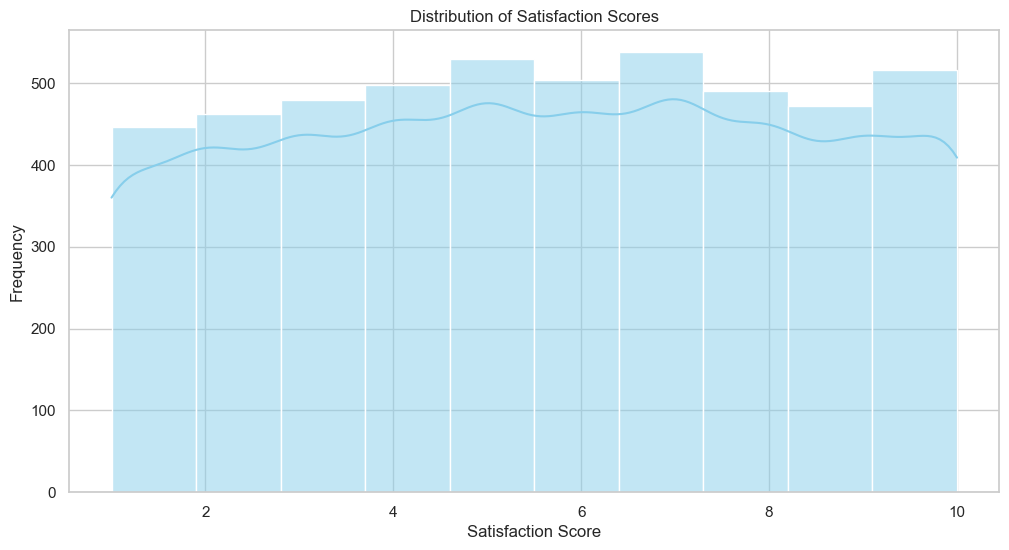

In [49]:

# --- Visualizations ---
sns.set(style="whitegrid")

# 1. **Satisfaction Score Distribution**
plt.figure(figsize=(12, 6))
sns.histplot(df_CF['Satisfaction_Score'], kde=True, bins=10, color='skyblue')
plt.title('Distribution of Satisfaction Scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.show()


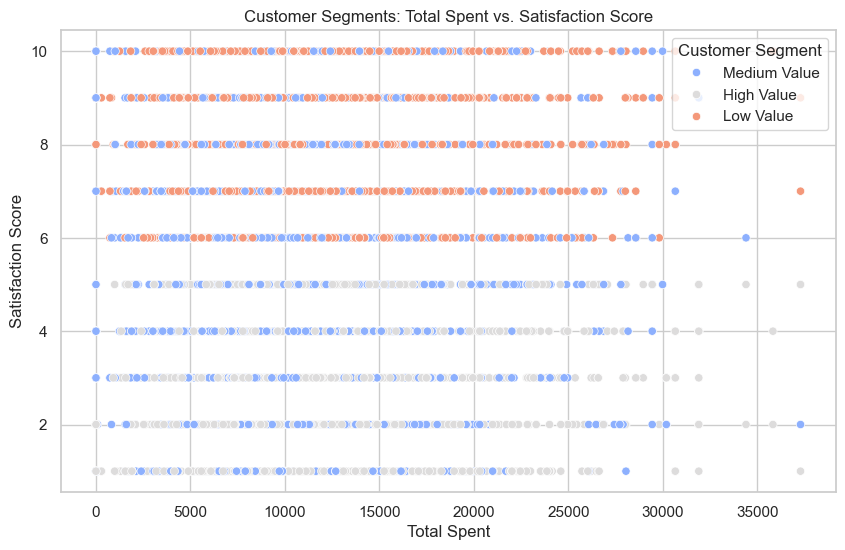

In [51]:

# 2. **Customer Segments Scatter Plot**
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_CF["Total_Spent"], y=df_CF["Satisfaction_Score"], hue=df_CF["Customer_Segment"], palette="coolwarm")
plt.title("Customer Segments: Total Spent vs. Satisfaction Score")
plt.xlabel("Total Spent")
plt.ylabel("Satisfaction Score")
plt.legend(title="Customer Segment")
plt.show()


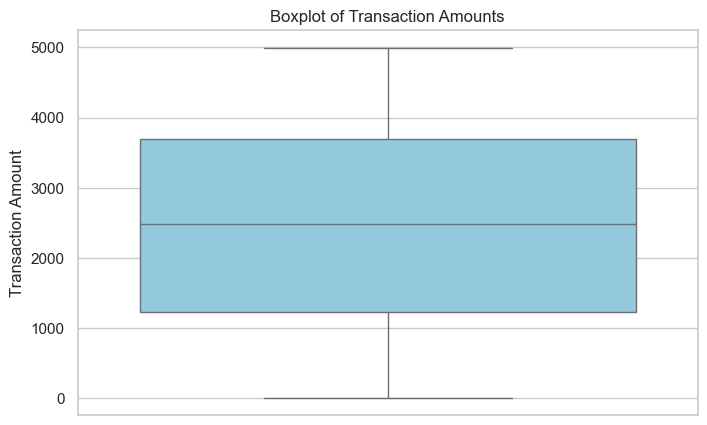

In [53]:

# 3. **Transaction Amount Boxplot**
plt.figure(figsize=(8, 5))
sns.boxplot(y=df_TD["Transaction_Amount"], color="skyblue")
plt.title("Boxplot of Transaction Amounts")
plt.ylabel("Transaction Amount")
plt.show()


C:\Users\Randy\AppData\Local\Temp\ipykernel_38468\3509585071.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_PO["Product_Type"], palette="viridis")


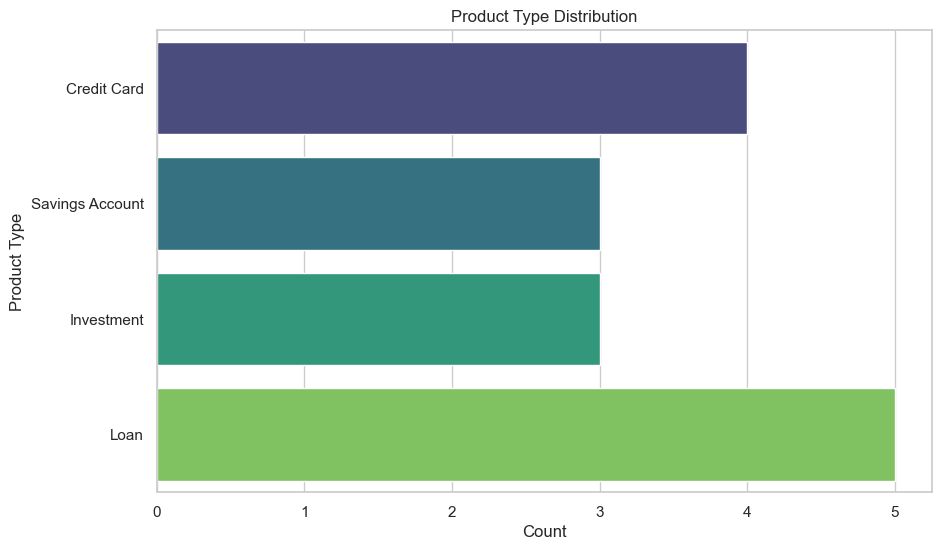

In [55]:

# 4. **Product Type Distribution**
plt.figure(figsize=(10, 6))
sns.countplot(y=df_PO["Product_Type"], palette="viridis")
plt.title("Product Type Distribution")
plt.xlabel("Count")
plt.ylabel("Product Type")
plt.show()


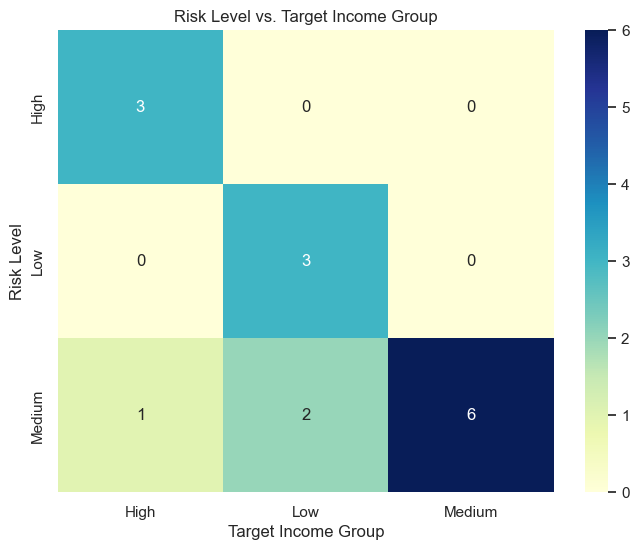

Processed datasets saved successfully!


In [57]:

# 5. **Heatmap: Risk Level vs Target Income Group**
plt.figure(figsize=(8, 6))
contingency_table = pd.crosstab(df_PO["Risk_Level"], df_PO["Target_Income_Group"])
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Risk Level vs. Target Income Group")
plt.xlabel("Target Income Group")
plt.ylabel("Risk Level")
plt.show()

# --- Save Processed Data ---
df_CF.to_csv("Milestone_1_Final.csv", index=False)
df_PO.to_csv("Processed_Product_Offering.csv", index=False)
df_TD.to_csv("Processed_Transaction_Data.csv", index=False)

print("Processed datasets saved successfully!")